# Real or Not? NLP with Disaster Tweets

In [1]:
import pandas as pd
import numpy as np 
import re
import time

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve

from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt 

In [2]:
# read files
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train_df["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [4]:
print("Examples of real disaster tweets : ")
print(train_df[train_df["target"] == 1]["text"][0:10])

Examples of real disaster tweets : 
0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object


In [5]:
print("Examples of unreal disaster tweets : ")
print(train_df[train_df["target"] == 0]["text"][0:10])

Examples of unreal disaster tweets : 
15                  What's up man?
16                   I love fruits
17                Summer is lovely
18               My car is so fast
19    What a goooooooaaaaaal!!!!!!
20          this is ridiculous....
21               London is cool ;)
22                     Love skiing
23           What a wonderful day!
24                        LOOOOOOL
Name: text, dtype: object


In [6]:
import string
#len shows the length of words excluding whitespaces in a message body.
train_df['len'] = train_df['text'].apply(lambda x : len(x) -x.count(" "))

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text)-text.count(" ")),3)*100
#punct shows the percentage of punctuation marks in a message body.
train_df['punct'] = train_df['text'].apply(lambda x : count_punct(x))

train_df.head()

,id,keyword,location,text,target,len,punct
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,1.8
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,3.1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,2.7
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,3.5
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,2.8


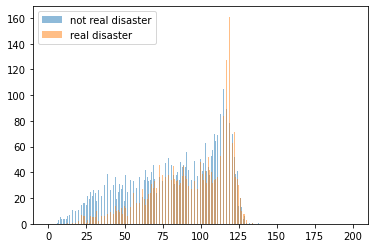

In [7]:
import matplotlib.pyplot as plt

bins = np.linspace(0,200,400)

plt.hist(train_df[train_df['target']==0]['len'],bins,alpha=0.5,label='not real disaster')
plt.hist(train_df[train_df['target']==1]['len'],bins,alpha=0.5,label='real disaster')
plt.legend(loc='upper left')
plt.show()


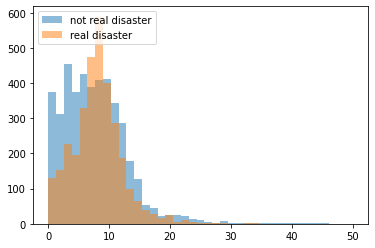

In [8]:
bins = np.linspace(0,50,40)

plt.hist(train_df[train_df['target']==0]['punct'],bins,alpha=0.5,label='not real disaster')
plt.hist(train_df[train_df['target']==1]['punct'],bins,alpha=0.5,label='real disaster')
plt.legend(loc='upper left')
plt.show()

In [9]:
# split of dataframe into the validation and training dataframe
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size = 0.2)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

train_vectors = vectorizer.fit_transform(train_df["text"])
val_vectors = vectorizer.transform(val_df["text"])
test_vectors = vectorizer.transform(test_df["text"])

In [11]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer()

# train_vectors = vectorizer.fit_transform(train_df["text"])
# val_vectors = vectorizer.transform(val_df["text"])
# test_vectors = vectorizer.transform(test_df["text"])

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

normalizer = "MinMax"

if normalizer == "StandardScaler":
    normalizer = StandardScaler()
    train_array = normalizer.fit_transform(train_vectors.toarray())
    val_array = normalizer.transform(val_vectors.toarray())
    test_array = normalizer.transform(test_vectors.toarray())
else :
    normalizer = MinMaxScaler()
    train_array = normalizer.fit_transform(train_vectors.toarray())
    val_array = normalizer.transform(val_vectors.toarray())
    test_array = normalizer.transform(test_vectors.toarray())


In [14]:
import random 

def noise_data(data_array,proba_threshold=0.3):
    """
    We change some values (from 0 to 1 and vice-versa) in the vector representing a sentence for proba_threshold %
    of the vectors.
    """
    nb_change = [0,0]
    for i in range(data_array.shape[0]):
        if random.randint(0,100)/100 <= proba_threshold:
            n = random.randint(1,10)
            for p in range(n):
                j = random.randint(0,data_array.shape[1]-1)
                data_array[i][j] = 1-data_array[i][j]
                nb_change[1]+=1
            nb_change[0]+=1
    print(nb_change)
    return data_array

train_array = noise_data(train_array)


[1858, 10168]


In [15]:
def model_preformances(true_values,predictions,name):
    model_confusion_matrix = confusion_matrix(true_values,predictions)
    model_accuracy_score = accuracy_score(true_values,predictions)
    model_recall_score = recall_score(true_values,predictions)
    model_precision_score = precision_score(true_values,predictions)
    model_f1_score = f1_score(true_values,predictions)
    print("======== " + name + " ========")
    print("Confusion matrix : \n",np.round(model_confusion_matrix,3))
    print("Accuracy score : \n",np.round(model_accuracy_score,3))
    print("Recall score : \n",np.round(model_recall_score,3))
    print("Precision score : \n",np.round(model_precision_score,3))
    print("F1 score : \n",np.round(model_f1_score,3))


    return model_confusion_matrix, model_accuracy_score, model_recall_score, model_precision_score, model_f1_score

# Ridge regression

In [16]:
def roc_curve_plot(true_values, predictions,name):
    fpr, tpr, threshold = roc_curve(true_values, predictions)
    roc_auc_sc = roc_auc_score(true_values, predictions)
    plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_sc))
    plt.title(name + ' AUC-ROC curve')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# NN

In [17]:
# KERAS
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras import regularizers

In [18]:
# definition of our keras model (using sequential neural network)
RNN_model = Sequential()
# add a hidden layer with 64 nodes with activation relu
RNN_model.add(Dense(256, input_dim=train_vectors.shape[1], activation='relu'))
# # add a little dropout 
RNN_model.add(Dropout(0.5))
# # add an other hidden layer with 32 nodes with activation relu
RNN_model.add(Dense(128, activation='relu'))
# # add a little dropout
RNN_model.add(Dropout(0.5))
# add an other hidden layer with 16 nodes with activation relu
RNN_model.add(Dense(32, activation='relu'))
# add a little dropout
RNN_model.add(Dropout(0.5))
# add an other hidden layer with 8 nodes with activation relu
RNN_model.add(Dense(8, activation='relu'))
# add the output layer with activation sigmoid
RNN_model.add(Dense(1, activation='sigmoid'))

# compiling the model with binary_crossentropy loss, adam optimizer and accuracy metrics 
RNN_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# displaying the model
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               4748032   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 2

In [19]:
# training the model with training data
EPOCHS = 5
BATCH_SIZE = 8
# fiting model
history = RNN_model.fit(train_array, train_df["target"],
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    
    verbose=1,
    shuffle=True,
    validation_data = (val_array,val_df["target"]))

Epoch 1/5
762/762 [==============================] - 20s 26ms/step - loss: 0.5588 - accuracy: 0.7189 - val_loss: 0.4578 - val_accuracy: 0.7912
Epoch 2/5
762/762 [==============================] - 19s 25ms/step - loss: 0.3127 - accuracy: 0.8824 - val_loss: 0.4815 - val_accuracy: 0.7853
Epoch 3/5
762/762 [==============================] - 19s 26ms/step - loss: 0.1544 - accuracy: 0.9511 - val_loss: 0.6480 - val_accuracy: 0.7840
Epoch 4/5
762/762 [==============================] - 19s 25ms/step - loss: 0.0738 - accuracy: 0.9772 - val_loss: 0.7842 - val_accuracy: 0.7741
Epoch 5/5
762/762 [==============================] - 19s 25ms/step - loss: 0.0475 - accuracy: 0.9859 - val_loss: 1.0236 - val_accuracy: 0.7649


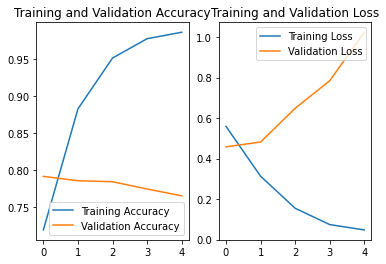

191/191 [==============================] - 1s 4ms/step - loss: 1.0236 - accuracy: 0.7649
Neural Network accuracy :  0.7649376392364502


In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']


plt.figure()
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# evaluation of model accuracy
_ , nn_acc = RNN_model.evaluate(val_array, val_df["target"], batch_size=BATCH_SIZE)
print('Neural Network accuracy : ', nn_acc)

In [21]:
def RNN_predict(vec_sentence,model=RNN_model):
    """
    This function takes a sentence's vector and returns the output of the neural network (rounded to 0 or 1).
    """
    return np.round(model.predict(vec_sentence))


# results of the predictions with trained neural network
NN_pred = [elt[0] for elt in RNN_predict(val_array)]

In [22]:
nn_confusion_matrix, nn_accuracy_score, nn_recall_score, nn_precision_score, nn_f1_score = model_preformances(val_df["target"],NN_pred,"Neural Network")

======== Neural Network ========
Confusion matrix : 
 [[727 148]
 [210 438]]
Accuracy score : 
 0.765
Recall score : 
 0.676
Precision score : 
 0.747
F1 score : 
 0.71


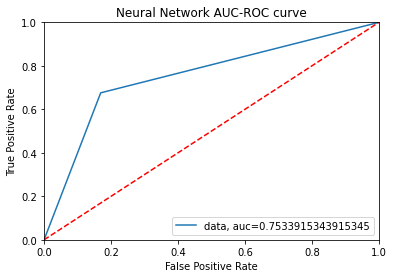

In [23]:
# calculate the false positive rate fpr and true positive tpr for all thresholds of the classification
roc_curve_plot(val_df["target"], NN_pred,"Neural Network")

In [25]:
clfs = {
'GNB': GaussianNB(),
'MNG': MultinomialNB(), 
'BNB' : BernoulliNB(),
'RDG' : RidgeClassifier(),
'LOG' : LogisticRegression(random_state=1),
'CART' : DecisionTreeClassifier(random_state=1,criterion='gini'),
'ID3' : DecisionTreeClassifier(random_state=1,criterion='entropy'),
'KNN': KNeighborsClassifier(n_neighbors=5),
'RF': RandomForestClassifier(n_estimators=50, random_state=1),
'BGC': BaggingClassifier(n_estimators=50),
'ADB': AdaBoostClassifier(n_estimators=50)
}

In [26]:
def run_classifiers(clfs, input_training_data,output_training_data, input_testing_data,output_testing_data):
    
    for i in clfs:
        t0 = time.time()
        clf = clfs[i]
        clf.fit(input_training_data,output_training_data)

        model_prediction = clf.predict(input_testing_data)

        model_confusion_matrix, model_accuracy_score, model_recall_score, model_precision_score, model_f1_score = model_preformances(output_testing_data,model_prediction,i)

        print("Total : {0:.3f}".format(time.time()-t0))
        print()
        print()

In [27]:
run_classifiers(clfs, train_array, train_df["target"], val_array,val_df["target"])

======== GNB ========
Confusion matrix : 
 [[398 477]
 [141 507]]
Accuracy score : 
 0.594
Recall score : 
 0.782
Precision score : 
 0.515
F1 score : 
 0.621
Total : 3.992


======== MNG ========
Confusion matrix : 
 [[760 115]
 [207 441]]
Accuracy score : 
 0.789
Recall score : 
 0.681
Precision score : 
 0.793
F1 score : 
 0.733
Total : 0.413


======== BNB ========
Confusion matrix : 
 [[799  76]
 [250 398]]
Accuracy score : 
 0.786
Recall score : 
 0.614
Precision score : 
 0.84
F1 score : 
 0.709
Total : 1.842


======== RDG ========
Confusion matrix : 
 [[739 136]
 [213 435]]
Accuracy score : 
 0.771
Recall score : 
 0.671
Precision score : 
 0.762
F1 score : 
 0.714
Total : 17.828


======== LOG ========
Confusion matrix : 
 [[756 119]
 [209 439]]
Accuracy score : 
 0.785
Recall score : 
 0.677
Precision score : 
 0.787
F1 score : 
 0.728
Total : 6.378


======== CART ========
Confusion matrix : 
 [[692 183]
 [226 422]]
Accuracy score : 
 0.731
Recall score : 
 0.651
Precision 

# Submission with Multinomial Naive Bayes

## Performances on validation test

- **Confusion matrix** : 
 ```
 [[760 115]
 [207 441]]
 ```
- **Accuracy score** : 0.789
- **Recall score** : 0.681
- **Precision score** : 0.793
- **F1 score** : 0.733
- **Total** : 0.413


======== mnb Regression ========
Confusion matrix : 
 [[760 115]
 [207 441]]
Accuracy score : 
 0.789
Recall score : 
 0.681
Precision score : 
 0.793
F1 score : 
 0.733


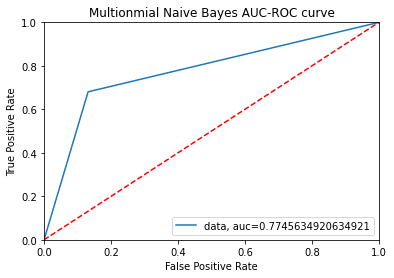

In [31]:
mnb_clf = MultinomialNB()

mnb_clf.fit(train_array, train_df["target"])

mnb_pred = mnb_clf.predict(val_array)

mnb_confusion_matrix, mnb_accuracy_score, mnb_recall_score, mnb_precision_score, mnb_f1_score = model_preformances(val_df["target"],mnb_pred,"mnb Regression")

roc_curve_plot(val_df["target"], mnb_pred,"Multionmial Naive Bayes")


sample_submission = pd.read_csv("../data/sample_submission.csv")
sample_submission["target"] = mnb_clf.predict(test_array)
sample_submission.to_csv("first_submission.csv", index=False)